In [70]:
from datasets import load_dataset

dataset = load_dataset('snli')

labels = dataset.unique("label").keys()
num_labels = len(labels)
# label -1 is used if the gold label is missing, see: https://github.com/huggingface/datasets/issues/296
# therefore we remove all entries with label -1
dataset = dataset.filter(lambda x: x["label"] != -1)

# shuffle the dataset to avoid any bias
dataset = dataset.shuffle(seed=42)

# rename label to labels, because the model expects a column named labels
dataset = dataset.rename_column("label", "labels")

print(f"{labels=}")
print(f"{num_labels=}")

labels=dict_keys(['test', 'validation', 'train'])
num_labels=3


In [71]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
from transformers import BertModel

import torch.nn as nn

class NLIClassifier(nn.Module):
    def __init__(self, model, num_labels=3, freeze_bert=False):
        super(NLIClassifier, self).__init__()
        self.bert = model.to(device)
        # freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

        for param in self.classifier.parameters():
            param.requires_grad = True
        self.to(device)

    def forward(self, input_ids, attention_mask, token_type_ids, labels):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_output = outputs.last_hidden_state[:, 0, :]  # Extract [CLS] token representation
        logits = self.classifier(cls_output)
        return logits

model = BertModel.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels,
    torch_dtype="auto",
).to(device)
nli_model = NLIClassifier(model, num_labels=3)
criterion = nn.CrossEntropyLoss()

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# tokenize dataset
tokenized_dataset = dataset.map(lambda x: tokenizer(x["premise"], x["hypothesis"], add_special_tokens=True, truncation=True), batched=True)


In [ ]:

tokenized_dataset

In [75]:
# Dataloader with collate function moving data to device
# batch.items() returns probably something like this: 
#[
#  ('input_ids', tensor([[101, 2054, 2003, 2023, 102], [101, 2029, 3185, 2003, 102]])),
#  ('attention_mask', tensor([[1, 1, 1, 1, 1], [1, 1, 1, 1, 1]])),
#  ('labels', tensor([0, 1]))
#]
# so we do not need the keys, just the values and send them to the device
def collate_fn_with_device(batch):
    batch = data_collator(batch)
    return {k: v.to(device) for k, v in batch.items()}

In [76]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

# remove all text columns, because they are already tokenized
tokenized_dataset = tokenized_dataset.remove_columns(["premise", "hypothesis"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)
traindataloader = DataLoader(tokenized_dataset["train"], batch_size=32, shuffle=True, collate_fn=collate_fn_with_device)
evaldataloader = DataLoader(tokenized_dataset["validation"], batch_size=32, shuffle=True, collate_fn=collate_fn_with_device)


In [80]:
class Results:
    def __init__(self):
        self.loss = []
        self.acc = []
        self.epoch = []

    def add(self, loss, acc, epoch):
        self.loss.append(loss.item())
        self.acc.append(acc)
        self.epoch.append(epoch)

    def __str__(self):
        return f"Loss: {self.loss}, Accuracy: {self.acc}, Epoch: {self.epoch}"

In [83]:
from torch.optim import AdamW
# optimizer = AdamW(nli_model.parameters(),lr=5e-5)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, nli_model.parameters()), lr=5e-5)

from transformers import get_scheduler
num_epochs = 3
num_training_steps = num_epochs * len(traindataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)


from tqdm.auto import tqdm
import evaluate

metric = evaluate.load("accuracy")

progress_bar = tqdm(range(num_training_steps))
nli_model.to(device)
nli_model.train()

training_results = Results()
validation_results = Results()
i = 1
j = 1
# https://discuss.pytorch.org/t/how-to-calculate-the-validation-loss-during-each-epoch-of-training/145272/3
for epoch in range(num_epochs):
    nli_model.train()
    for batch in traindataloader:
        optimizer.zero_grad()
        outputs = nli_model(**batch)
        loss = criterion(outputs, batch["labels"])
        train_acc = (torch.argmax(outputs, dim=-1) == batch["labels"]).float().mean()
        current_epoch = i / len(traindataloader)
        training_results.add(loss, train_acc.item(), current_epoch)

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)
        i += 1
    nli_model.eval()
    for batch_eval in evaldataloader:
        # for model inference we don't need gradients
        with torch.no_grad():
            outputs_eval = nli_model(**batch_eval)
        current_epoch = j / len(evaldataloader)
        acc = (torch.argmax(outputs_eval, dim=-1) == batch_eval["labels"]).float().mean()
        loss = criterion(outputs_eval, batch_eval["labels"])
        validation_results.add(loss, acc.item(), current_epoch)
        j += 1

torch.save(model, "model.pth")


  0%|          | 0/51504 [00:00<?, ?it/s]

In [85]:
testdataloader = DataLoader(tokenized_dataset["test"], batch_size=32, shuffle=True, collate_fn=collate_fn_with_device)

In [ ]:
import evaluate

metric = evaluate.load("accuracy")
nli_model.eval()
for batch in testdataloader:
    # for model inference we don't need gradients
    with torch.no_grad():
        outputs = nli_model(**batch)
    predictions = torch.argmax(outputs, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

print("Accuracy:", metric.compute()['accuracy'])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import evaluate

metric = evaluate.load("confusion_matrix")
nli_model.eval()
for batch in testdataloader:
    # for model inference we don't need gradients
    with torch.no_grad():
        outputs = nli_model(**batch)

    predictions = torch.argmax(outputs, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])
# Compute confusion matrix
# Load confusion matrix metric
metric = evaluate.load("confusion_matrix")

nli_model.eval()

# Iterate through the test dataloader
for batch in testdataloader:
    with torch.no_grad():
        outputs = nli_model(**batch)
        predictions = torch.argmax(outputs, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])

# Compute confusion matrix
conf_matrix = metric.compute()['confusion_matrix']

labels = ["Neutral", "Entailment", "Contradiction"]

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import pickle

# see https://stackoverflow.com/questions/4529815/saving-an-object-data-persistence

with open('training.pkl', 'wb') as outp:
    pickle.dump(training_results, outp, pickle.HIGHEST_PROTOCOL)

with open('validation.pkl', 'wb') as outp:
    pickle.dump(validation_results, outp, pickle.HIGHEST_PROTOCOL)

/tmp/ipykernel_2048/3907176887.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)


<Figure size 800x600 with 0 Axes>

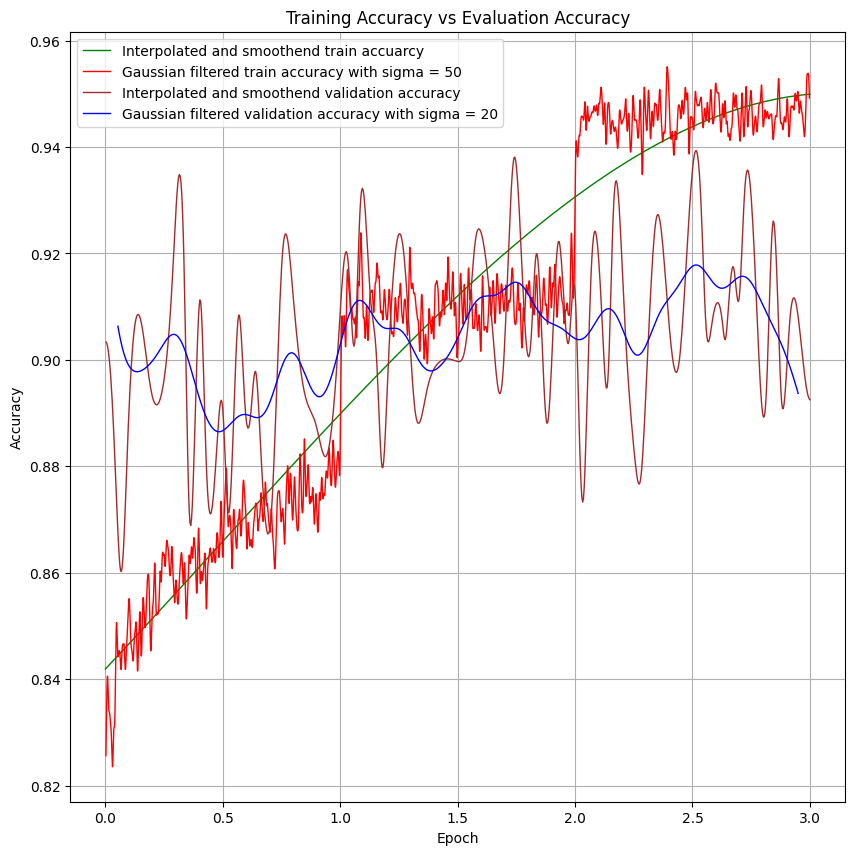

In [136]:
import matplotlib.pyplot as plt
import numpy as np

from scipy import interpolate

from scipy import ndimage

plt.figure(figsize=(8, 6))

# convert both to arrays
train_x = np.array(training_results.epoch)
train_y = np.array(training_results.acc)

# convert both to arrays
val_x = np.array(validation_results.epoch)
val_y = np.array(validation_results.acc)

train_spl = interpolate.UnivariateSpline(training_results.epoch, training_results.acc)
val_spl = interpolate.UnivariateSpline(validation_results.epoch, validation_results.acc, s=2.5)

sigma = 50
train_g_x = ndimage.gaussian_filter1d(train_x, sigma)
train_g_y = ndimage.gaussian_filter1d(train_y, sigma)
val_g_x = ndimage.gaussian_filter1d(val_x, 20)
val_g_y = ndimage.gaussian_filter1d(val_y, 20)

fig, ax = plt.subplots(figsize=(10, 10))
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)

plt.plot(train_x, train_spl(train_x), 'green', linewidth=1, label='Interpolated and smoothend train accuarcy')
plt.plot(train_g_x, train_g_y, 'red', linewidth=1, label='Gaussian filtered train accuracy with sigma = 50')
plt.plot(val_x, val_spl(val_g_x), 'brown', linewidth=1, label='Interpolated and smoothend validation accuracy')
plt.plot(val_g_x, val_g_y, 'blue', linewidth=1, label='Gaussian filtered validation accuracy with sigma = 20')
# Labels and Title
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training Accuracy vs Evaluation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('training_acc_vs_eval_acc.png')
#plt.show()

/tmp/ipykernel_2048/2713088244.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)


<Figure size 800x600 with 0 Axes>

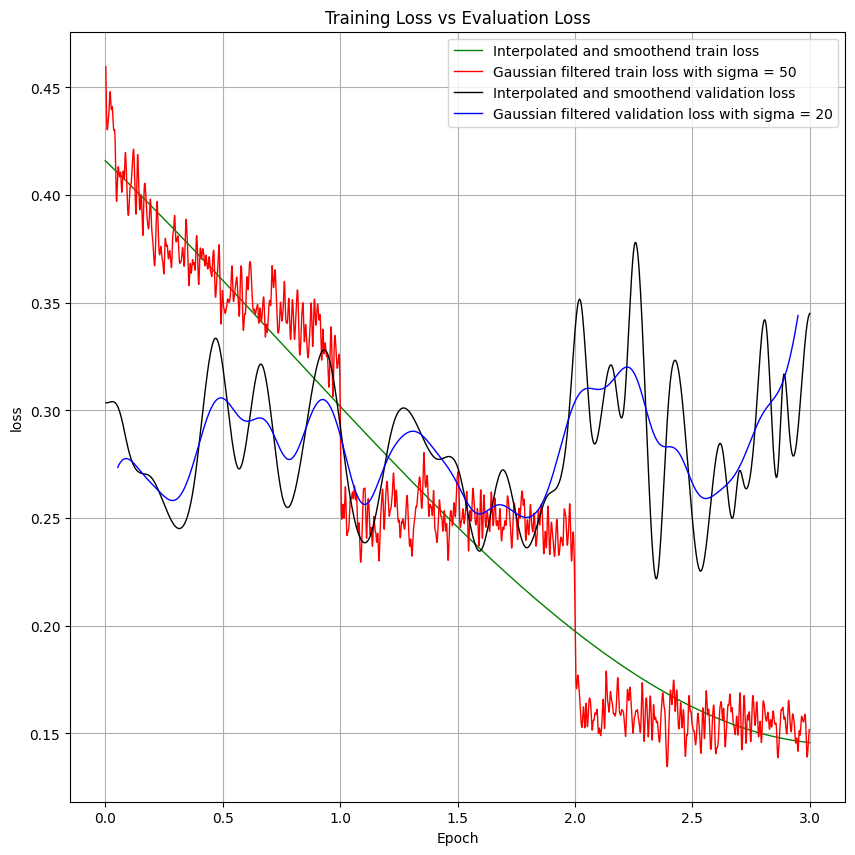

In [135]:
import matplotlib.pyplot as plt
import numpy as np

from scipy import interpolate

from scipy import ndimage

plt.figure(figsize=(8, 6))

# convert both to arrays
train_x = np.array(training_results.epoch)
train_y = np.array(training_results.loss)

# convert both to arrays
val_x = np.array(validation_results.epoch)
val_y = np.array(validation_results.loss)

train_spl = interpolate.UnivariateSpline(training_results.epoch, training_results.loss)
val_spl = interpolate.UnivariateSpline(validation_results.epoch, validation_results.loss, s=20)

sigma = 50
train_g_x = ndimage.gaussian_filter1d(train_x, sigma)
train_g_y = ndimage.gaussian_filter1d(train_y, sigma)
val_g_x = ndimage.gaussian_filter1d(val_x, 20)
val_g_y = ndimage.gaussian_filter1d(val_y, 20)

fig, ax = plt.subplots(figsize=(10, 10))
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)

plt.plot(train_x, train_spl(train_x), 'green', linewidth=1, label='Interpolated and smoothend train loss')
plt.plot(train_g_x, train_g_y, 'red', linewidth=1, label='Gaussian filtered train loss with sigma = 50')
plt.plot(val_x, val_spl(val_g_x), 'black', linewidth=1, label='Interpolated and smoothend validation loss')
plt.plot(val_g_x, val_g_y, 'blue', linewidth=1, label='Gaussian filtered validation loss with sigma = 20')
# Labels and Title
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.title('Training Loss vs Evaluation Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_loss_vs_eval_loss.png')
#plt.show()